# Setting up transmorph within a scanpy workflow

In this tutorial, we will showcase how to implement a **transmorph** integration pipeline within a scanpy workflow. This tutorial is inspired from the [scanpy integration tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html), and will follow similar steps. You will learn here how to use transmorph carry out data integration and label transfer between AnnData objects.

Let us start by loading scanpy, and adjusting a few settings.

In [ ]:
import scanpy as sc
import warnings

sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')
warnings.filterwarnings('ignore')

## Datasets presentation

In this tutorial we will use two PBMC datasets: 

In [85]:
adata_pbmc3k = sc.datasets.pbmc3k_processed()
adata_pbmc68k = sc.datasets.pbmc68k_reduced()

# We create a container for easier handling
adatas = {
    "pbmc3k_ref": adata_pbmc3k,
    "pbmc68k_qry": adata_pbmc68k
}

Let us describe these datasets a little bit. PBMC3K will be used as a "reference" or "atlas" dataset in this example for labels truth as it is by far the larger and contains clustering-based labels, while PBMC68K will be the query dataset. PBMC68K contains "bulk" label, but as we will see closer inspection will reveal they seem quite mixed up.

In [44]:
for name, adata in adatas.items():
    print(f"-- Dataset {name}")
    print(f"> {adata.n_obs} obs x {adata.n_vars} vars")
    labels = adata.obs['louvain'] if name == 'pbmc3k_ref' else adata.obs['bulk_labels']
    all_classes = set(labels)
    print(f"> {len(all_classes)} labels")
    for cl_name in all_classes:
        print(f"..{sum(labels == cl_name)} {cl_name}")

-- Dataset pbmc3k_ref
> 2638 obs x 1838 vars
> 8 labels
..1144 CD4 T cells
..15 Megakaryocytes
..37 Dendritic cells
..154 NK cells
..342 B cells
..316 CD8 T cells
..480 CD14+ Monocytes
..150 FCGR3A+ Monocytes
-- Dataset pbmc68k_qry
> 700 obs x 765 vars
> 10 labels
..8 CD4+/CD45RA+/CD25- Naive T
..54 CD8+ Cytotoxic T
..31 CD56+ NK
..43 CD8+/CD45RA+ Naive Cytotoxic
..13 CD34+
..240 Dendritic
..95 CD19+ B
..68 CD4+/CD25 T Reg
..19 CD4+/CD45RO+ Memory
..129 CD14+ Monocyte


Let us first have a look at the "atlas" dataset, PBMC3K. It has been clustered using the Louvain algorithm, and clusters have been labeled with cell types using marker genes. We hope to leverage these annotations to refine the labeling of the other dataset, PBMC68K.

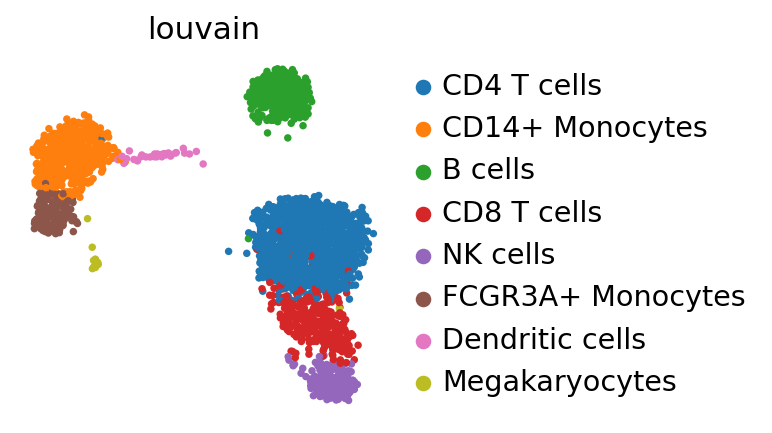

In [46]:
sc.pl.umap(adatas['pbmc3k_ref'], color=['louvain'])

Let us now check the query dataset. As we saw, it contains much lesser cells, with bulk annotations. We first run two different clustering on them, one with "large" clusters and one with "small" clusters. It will be useful to specifically refer or target populations of cells. We also display the bulk annotations; as we can see, there is a large portion of cells that are annotated as dendritic, while our atlas does not contain this many examples of dendritic cells. This imply we will have to be careful in regard of this specific annotation, and could for instance motivate usage of data augmentation. This is unrelated to transmorph, and beyond the scope of this tutorial so we won't do it there.

Furthermore, we see cluster 1 in leiden_.1 which seems to be mixed between monocytes and dendritic cells. We hope atlas annotation will help us concluding if there is mislabeling here. Finally, we can see cluster 0 in leiden_.1 contains mixed annotations referring to different types of lymphocytes. We hope label transfer from atlas will be able to preserve some of this diversity.

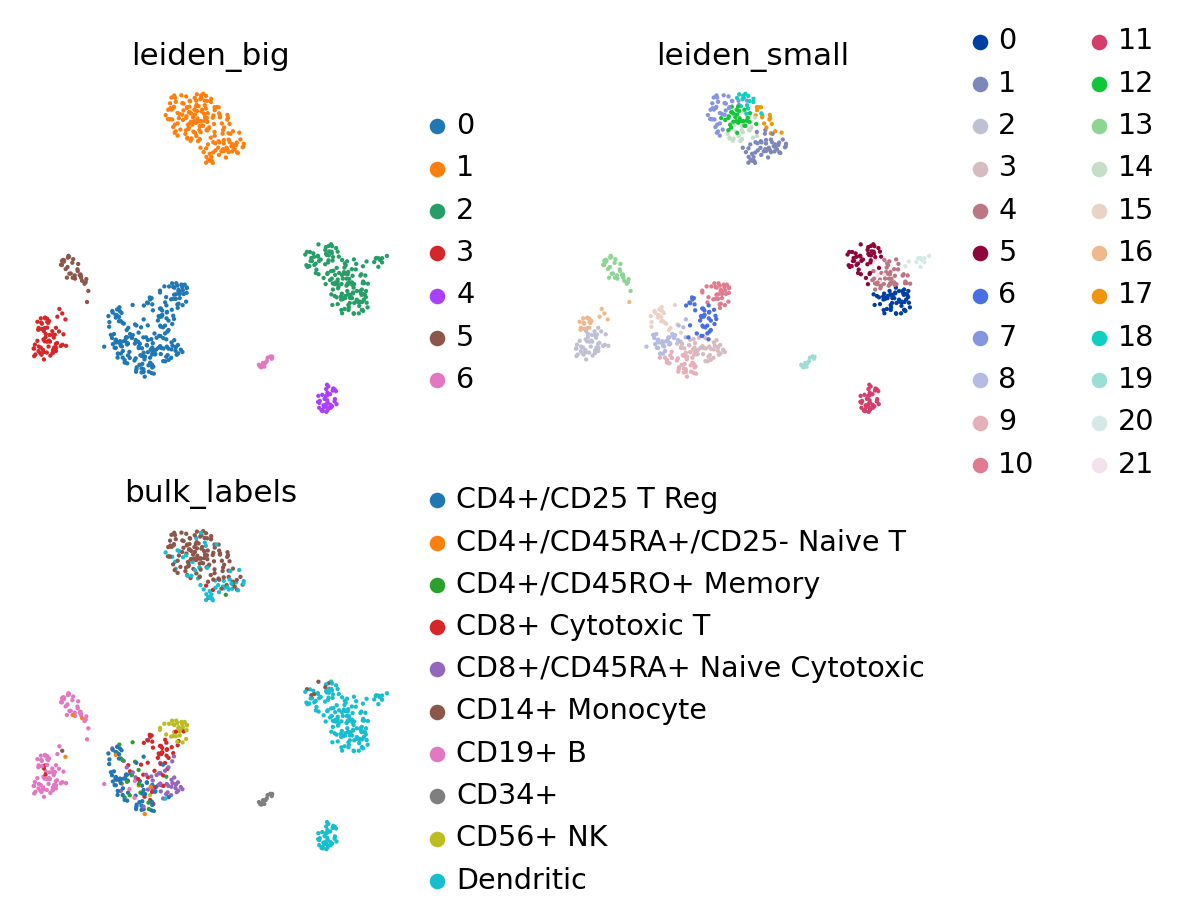

In [91]:
sc.tl.leiden(adatas['pbmc68k_qry'], resolution=.2, key_added="leiden_big")
sc.tl.leiden(adatas['pbmc68k_qry'], resolution=3, key_added="leiden_small")
sc.pl.umap(adatas['pbmc68k_qry'], color=['leiden_big', 'leiden_small', 'bulk_labels'], s=15, ncols=2)

## Dataset integration

Let us load a data integration model, for instance a MNN-based one and carry out the integration using the atlas dataset as a reference. As the query dataset is quite small, we tune down n_neighbors a little bit so that is stays specific.

In [ ]:
from transmorph.models import MNNCorrection

mnncorrection = MNNCorrection(lc_n_neighbors=5)
mnncorrection.transform(adatas, reference=adatas['pbmc3k_ref'])

## Label transfer

We can then carry out label transfer between datasets using the integrated representation of both datasets. To do so, we will use the *label_transfer_cluster* method from transmorph, which will take into account clustering information about the query dataset so that inferred label is homogeneous within a cluster. We pass the leiden_3 cluster key, as clusters are small enough to allow label diversity within a bigger cluster. *n_neighbors* is simply the parameter of the $k$-nearest neighbors classifier we use to infer label.

In [107]:
from transmorph.utils.infer import label_transfer_cluster

# We create a copy of the initial labels within the reference dataset.
# Inferred labels of query and initial labels of reference will be
# stored within the "cell_type" .obs key.
adatas['pbmc3k_ref'].obs['cell_type'] = adatas['pbmc3k_ref'].obs['louvain'].copy()
label_transfer_cluster(
    adatas, 
    reference=adatas['pbmc3k_ref'], 
    cluster='leiden_small',
    label="cell_type", 
    n_neighbors=3
)

We can then use standard scanpy tools to concatenate and display datasets together in a common umap space, using the X_transmorph key to compute the nearest neighbors graph.

In [105]:
adata_concat = adatas['pbmc68k_qry'].concatenate(
    adatas['pbmc3k_ref'], 
    batch_categories=['pbmc68k_qry', 'pbmc3k_ref']
)
sc.pp.neighbors(adata_concat, use_rep="X_transmorph")
sc.tl.umap(adata_concat)

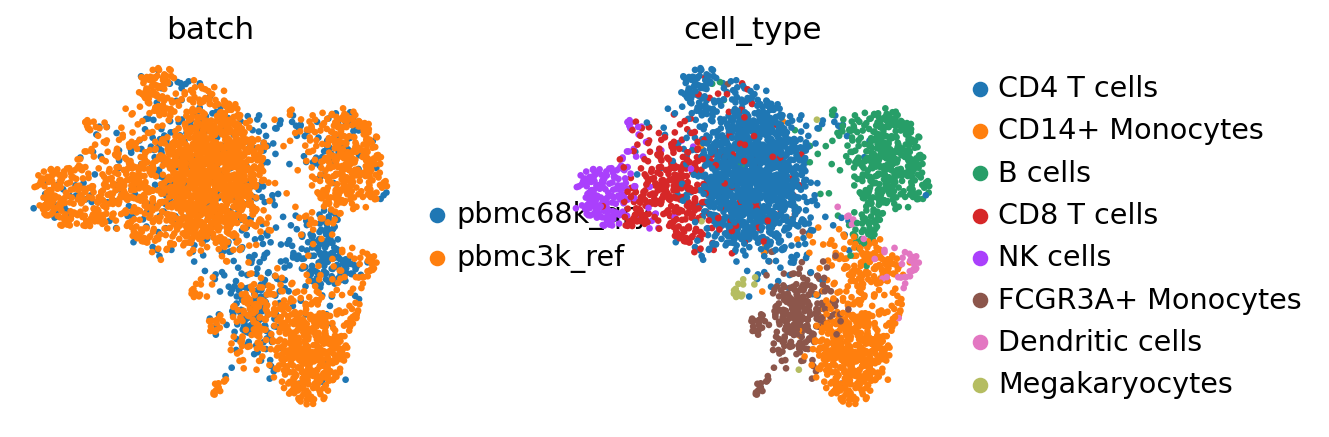

In [96]:
sc.pl.umap(adata_concat, color=['batch', 'cell_type'])

We can finally look at the inferred labels within the initial space. Most cell types are confirmed like NK cells, monocytes from cluster 1 which are disambiguoused, CD4 cells, CD8 cells, part of B cells. We can already see only few cells have been labeled as "dendritic" in the query dataset, as there are only a few examples in the atlas. CD34+ cells have also been missed, as there are none in the initial dataset. Cluster 0 has been labeled as monocytes quite unambiguously, so we will label it as monocyte. The general rule is to look at these atlas integration and labelings as "hints", and not as "ground truth".

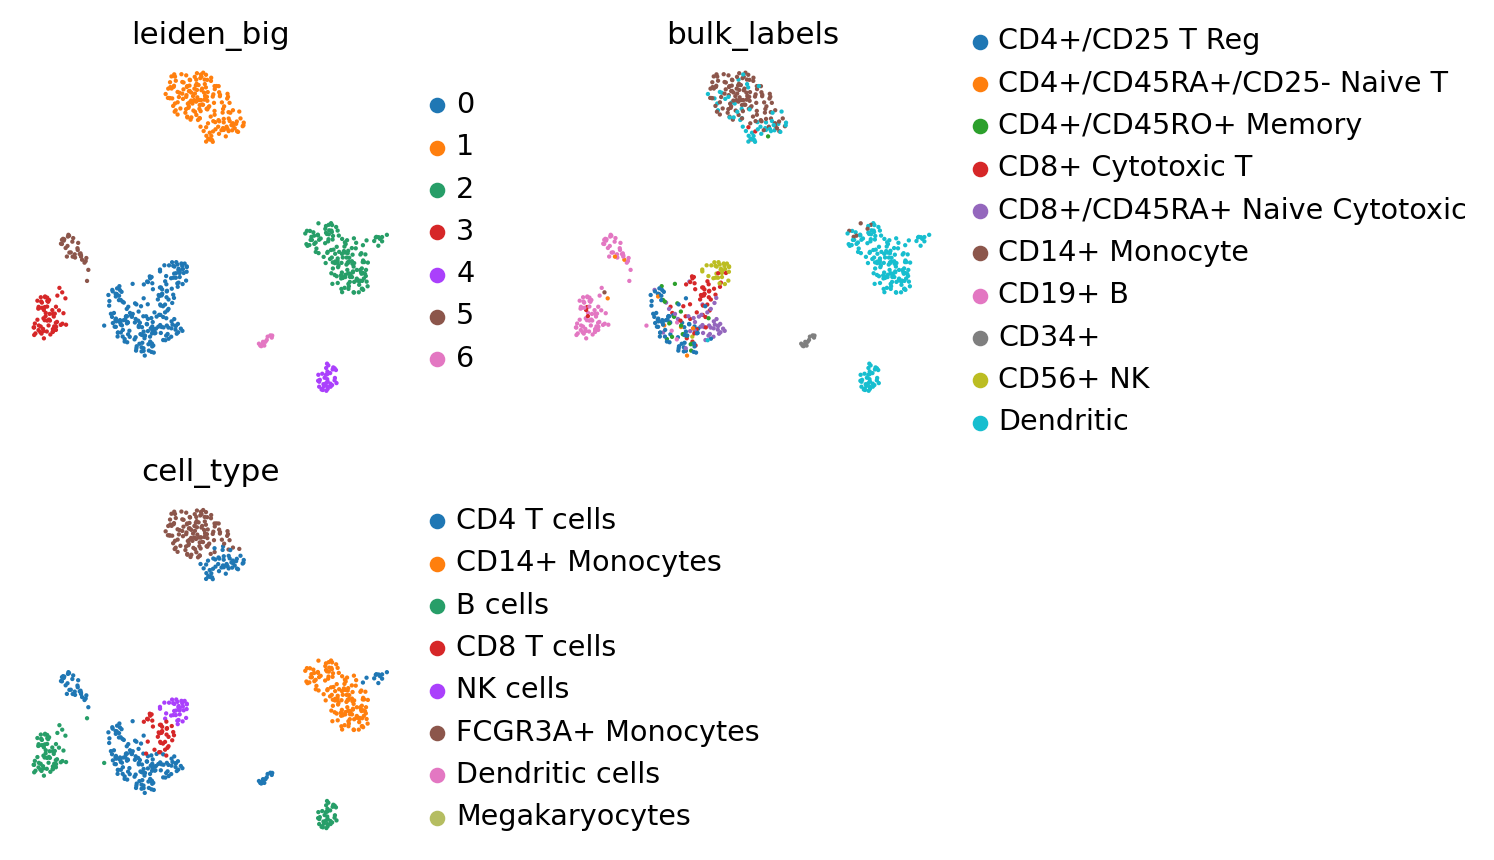

In [108]:
sc.pl.umap(adatas['pbmc68k_qry'], color=['leiden_big', 'bulk_labels', 'cell_type'], s=15, ncols=2)

Let us proceed to a few adjustments, based on the inferred annotations, bulk labels and common sense. Of course in real-life applications, we would also want to look at marker genes to support these intuitions.

In [109]:
def set_cell_type(adata, cluster, cell_type):
    if cell_type not in adata.obs['cell_type'].cat.categories:
        adata.obs['cell_type'].cat.add_categories(cell_type, inplace=True)
    adata.obs['cell_type'][adata.obs['leiden_big'] == cluster] = cell_type

set_cell_type(adatas['pbmc68k_qry'], '1', 'CD14+ Monocytes')
set_cell_type(adatas['pbmc68k_qry'], '2', 'Dendritic cells')
set_cell_type(adatas['pbmc68k_qry'], '4', 'Dendritic cells')
set_cell_type(adatas['pbmc68k_qry'], '6', 'CD34+')
set_cell_type(adatas['pbmc68k_qry'], '5', 'B cells')

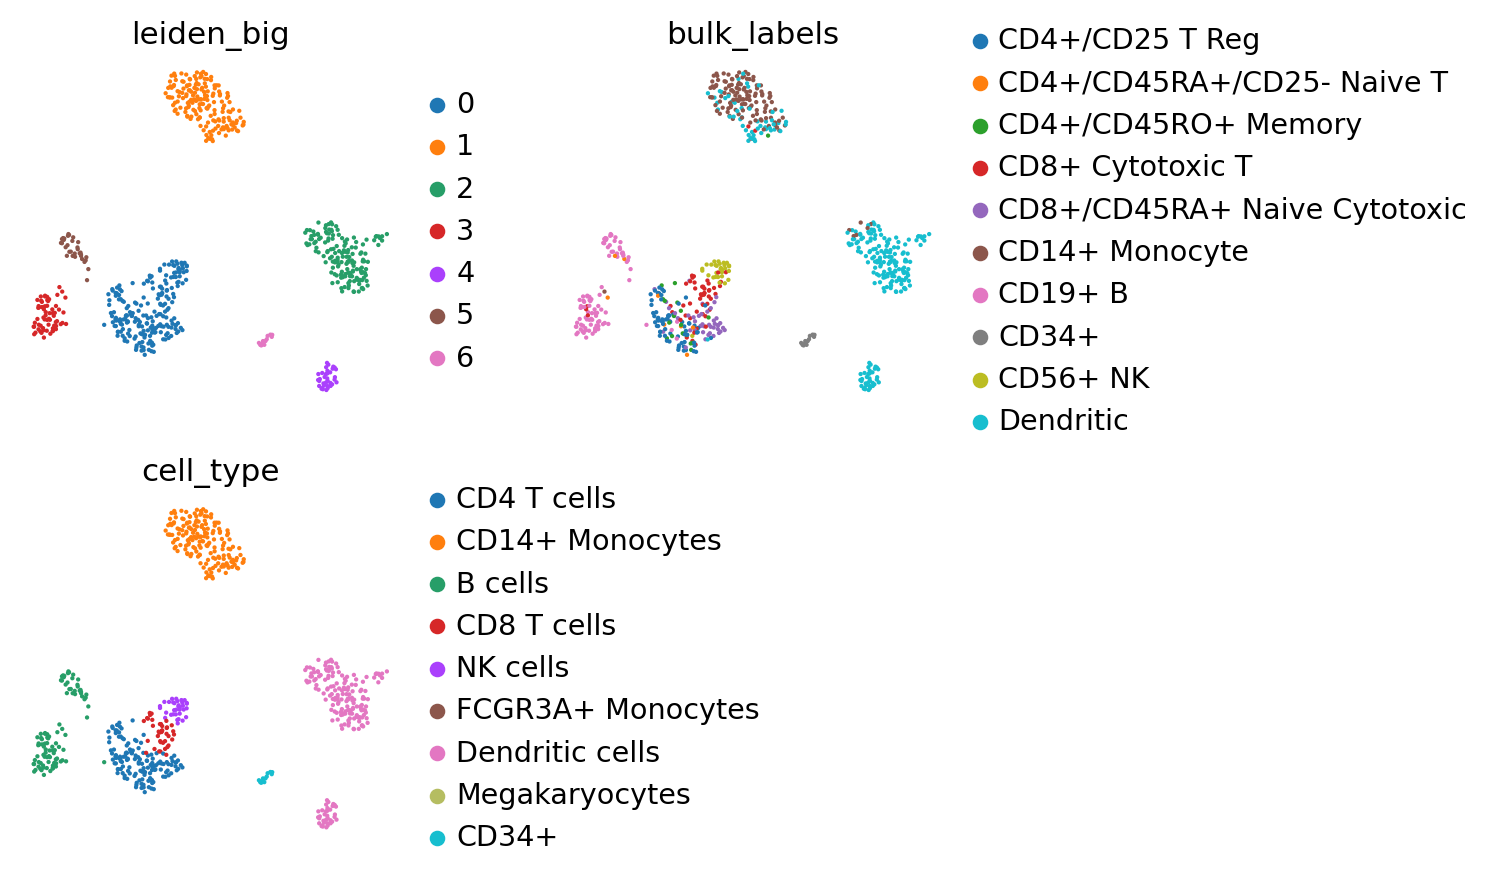

In [110]:
sc.pl.umap(adatas['pbmc68k_qry'], color=['leiden_big', 'bulk_labels', 'cell_type'], s=15, ncols=2)

The "cell_type" observation now contains refined labels that are less detailed but arguably more robust than "bulk_labels" ones. Indeed, they have been enriched by atlas integration, which allowed to enforce the presence of some cell types, and to remove ambiguities within certain clusters. In all cases, we must keep in mind this kind of strategy highly depends on atlas quality, and always require to check and refine labels afterwards.